In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("data.adult.csv")
data.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K


In [ ]:
(data == "?").sum()

age                 0
workclass         929
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        933
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64

In [7]:
data = data.replace("?", np.nan).dropna()

Напишите в чат, как найти выбросы (построить бокс плоты)?

<Axes: >

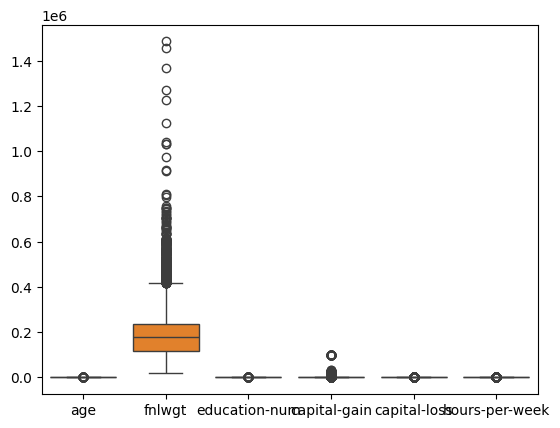

In [ ]:
sns.boxplot(data)

In [ ]:
# Как будем обрабатывать выбросы? Как посмотреть, сколько объектов имеют выброс по какому-либо признаку? Напишите в чат код

In [10]:
def outliers_z_score(
    data, feature, left_mod=3, right_mod=3, log_scale=False, return_cleaned=True
):
    """
    Функция для обработки выбросов с использованием Z-оценки.
    Параметры:
    - data: DataFrame, исходные данные.
    - feature: str, название столбца для обработки.
    - left_mod: float, множитель для нижней границы (по умолчанию 2.5).
    - right_mod: float, множитель для верхней границы (по умолчанию 2.5).
    - log_scale: bool, использовать логарифмическое преобразование (по умолчанию False).
    - return_cleaned: bool, возвращать очищенные данные (True) или данные с замененными выбросами (False).
    Возвращает:
    - DataFrame, обработанные данные.
    """
    # Логарифмическое преобразование (если нужно)
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
    # Расчет границ
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left_mod * sigma
    upper_bound = mu + right_mod * sigma
    # Определение выбросов
    is_outlier = (x < lower_bound) | (x > upper_bound)
    outliers = data[
        is_outlier
    ].copy()  # Копируем выбросы, чтобы избежать предупреждений
    cleaned = data[~is_outlier].copy()  # Копируем очищенные данные
    # Замена выбросов на модальное значение очищенных данных
    outliers[feature] = cleaned[feature].mode()
    # Объединение данных
    result = pd.concat([cleaned, outliers], axis=0).reset_index(drop=True)
    # Возврат результата
    if return_cleaned:
        return cleaned
    else:
        return result

In [ ]:
data = outliers_z_score(data, return_cleaned=True, feature="fnlwgt")

In [ ]:
from sklearn.model_selection import train_test_split

data, test = train_test_split(
    data, train_size=0.6, stratify=data[">50K,<=50K"], random_state=4
)
data.shape

(9114, 14)

Как понять, какие из признаков -- вещественные? (принадлежат к типу `np.number`)

In [18]:
df = data.select_dtypes(include=[np.number])

In [19]:
df.shape

(9114, 6)

In [ ]:
df[">50K,<=50K"] = data[">50K,<=50K"]

In [ ]:
sns.pairplot(df, hue=">50K,<=50K")

Как привести данные к единому масштабу (нормализовать)?

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
scaler = StandardScaler()

In [27]:
df = df.drop(columns=[">50K,<=50K"])

In [28]:
scaled_df = scaler.fit_transform(df)

In [30]:
scaled_df

array([[-0.5699431 ,  0.12600695, -0.45943054, -0.15016255, -0.22240602,
        -0.078439  ],
       [-1.17991699, -0.33771631, -0.064928  , -0.15016255, -0.22240602,
        -0.078439  ],
       [ 0.04003079,  0.08539697, -0.45943054, -0.15016255, -0.22240602,
        -0.078439  ],
       ...,
       [-0.49369636,  1.4904144 ,  1.11857961, -0.15016255, -0.22240602,
        -0.078439  ],
       [-1.02742352, -0.37532824, -0.064928  , -0.15016255, -0.22240602,
        -0.49248572],
       [-1.4086572 , -1.64636627, -0.064928  , -0.15016255, -0.22240602,
        -1.73462587]], shape=(9114, 6))

In [ ]:
target = data[">50K,<=50K"].replace({">50K": 0, "<=50K": 1})

/tmp/ipykernel_716098/1188540550.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target = data[">50K,<=50K"].replace({'>50K': 0, '<=50K': 1})


In [32]:
target.shape

(9114,)

Обучение на вещественных признаках

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [57]:
def grid_searcher(model, params, cv, fit_data, fit_target):
    grid_searcher = GridSearchCV(estimator=model, param_grid=params, cv=cv, verbose=1)
    grid_searcher.fit(fit_data, fit_target)
    print(grid_searcher.best_params_)
    return grid_searcher

In [35]:
n = 35
m_kNN = KNeighborsClassifier()
params_kNN = {"n_neighbors": range(1, n)}
gs_kNN = grid_searcher(m_kNN, params_kNN, 5, df, target)

{'n_neighbors': 17}


In [ ]:
m_decisionTree = DecisionTreeClassifier()
params_decisionTree = {"max_depth": range(1, n)}
gs_decisionTree = grid_searcher(m_decisionTree, params_decisionTree, 5, df, target)

{'max_depth': 5}


In [37]:
def plot_scores(*grid_searchers, params_name=None, labels=None):
    if not params_name:
        params_name = [f"param name {i}" for i in range(len(grid_searchers))]
    if not labels:
        labels = [f"label {i}" for i in range(len(grid_searchers))]
    plt.figure(figsize=(12, 5))
    for grid_searcher, param_name, label in zip(grid_searchers, params_name, labels):
        means = np.array(grid_searcher.cv_results_["mean_test_score"])
        stds = np.array(grid_searcher.cv_results_["std_test_score"])
        plt.plot(range(1, n), means, label=label)
        plt.fill_between(range(1, n), means + stds, means - stds, alpha=0.15)
        plt.plot(
            grid_searcher.best_params_[param_name],
            grid_searcher.best_score_,
            "ro",
            c="red",
        )
        plt.axvline(
            x=grid_searcher.best_params_[param_name], ls="--", c="red", alpha=0.5
        )
        plt.text(
            grid_searcher.best_params_[param_name] + 0.5,
            grid_searcher.best_score_,
            f"best score = {grid_searcher.best_score_:.3f}",
        )
    plt.xlim(1, n)
    plt.ylim(np.min(means - stds) - 0.1, 1)
    plt.xticks(np.arange(1, n, 2))
    plt.xlabel("Number of nearest neighbours/Max depth of desicion tree")
    plt.ylabel("Accuracy score")
    plt.legend()
    plt.show()

/tmp/ipykernel_716098/888913472.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(


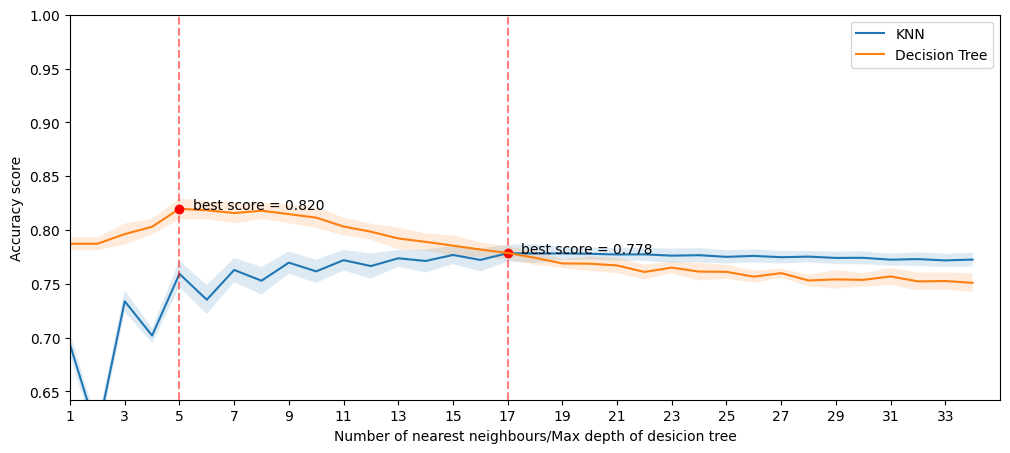

In [ ]:
plot_scores(
    gs_kNN,
    gs_decisionTree,
    params_name=["n_neighbors", "max_depth"],
    labels=["KNN", "Decision Tree"],
)

In [ ]:
n_est = 500
rf = RandomForestClassifier(n_estimators=n_est, random_state=12)
rf.fit(df, target)

RandomForestClassifier(n_estimators=500, random_state=12)

In [41]:
trees_scores = [est.score(df, target) for est in rf.estimators_]

/home/setupishe/AML_seminars2/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/setupishe/AML_seminars2/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/setupishe/AML_seminars2/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/setupishe/AML_seminars2/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/setupishe/AML_seminars2/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier 

In [ ]:
mean_score = [np.mean(trees_scores[: (i + 1)]) for i in range(n_est)]

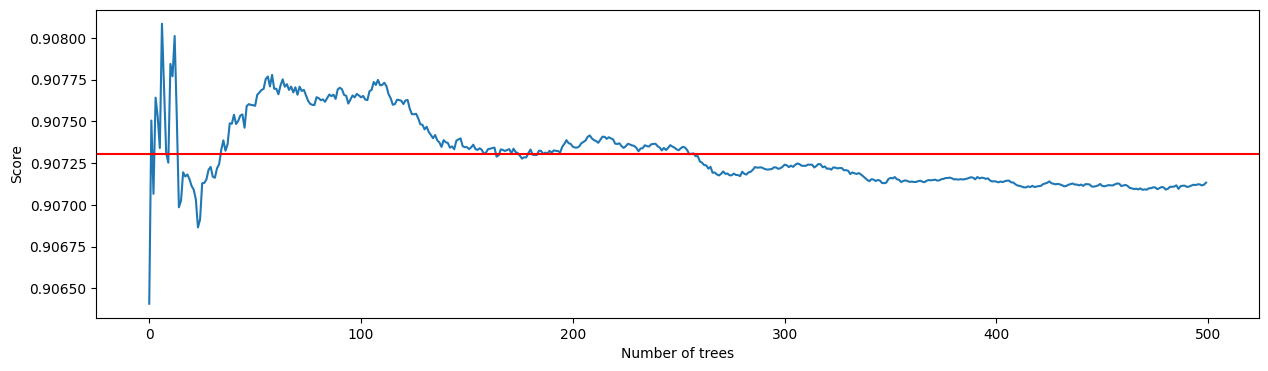

In [ ]:
s, fig = plt.subplots(1, 1, figsize=(15, 4))
fig.plot(range(n_est), mean_score)
fig.axhline(np.mean(mean_score), color="r")
fig.set_xlabel("Number of trees")
fig.set_ylabel("Score")
plt.show()

In [ ]:
best_n_est = 50
rf = RandomForestClassifier(n_estimators=best_n_est, random_state=4)

In [50]:
params_kNN = {
    "n_neighbors": range(1, n),
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"],
}
gs_kNN_2 = grid_searcher(m_kNN, params_kNN, 5, df, target)
print("kNN best score = ", gs_kNN_2.best_score_)

params_decisionTree = {"max_depth": range(1, n), "criterion": ["gini", "entropy"]}
gs_decisionTree_2 = grid_searcher(m_decisionTree, params_decisionTree, 5, df, target)
print("decisionTree best score = ", gs_decisionTree_2.best_score_)

params_randomForest = {
    "criterion": ["gini", "entropy"],
    "max_features": range(1, df.shape[1]),
}
gs_randomForest_2 = grid_searcher(rf, params_randomForest, 5, df, target)
print("randomForest best score = ", gs_randomForest_2.best_score_)

{'metric': 'euclidean', 'n_neighbors': 17}
kNN best score =  0.7783633086919005
{'criterion': 'gini', 'max_depth': 5}
decisionTree best score =  0.8193983090802787
{'criterion': 'gini', 'max_features': 5}
randomForest best score =  0.7977835355408059


In [51]:
best_n_est = 50
rf = RandomForestClassifier(n_estimators=best_n_est, random_state=4)

In [52]:
params_randomForest = {
    "criterion": ["gini", "entropy"],
    "max_features": range(1, df.shape[1]),
}
gs_randomForest_2 = grid_searcher(rf, params_randomForest, 5, df, target)
print("randomForest best score = ", gs_randomForest_2.best_score_)

{'criterion': 'entropy', 'max_features': 5}
randomForest best score =  0.7925173099190548


Добавим категориальные признаки

In [53]:
df = np.hstack((df, pd.get_dummies(data.select_dtypes(exclude=[np.number]))))
df.shape

(9114, 65)

In [60]:
params_kNN = {
    "n_neighbors": range(1, n),
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"],
}
gs_kNN_2 = grid_searcher(m_kNN, params_kNN, 5, df, target)
print("kNN best score = ", gs_kNN_2.best_score_)

params_decisionTree = {"max_depth": range(1, n), "criterion": ["gini", "entropy"]}
gs_decisionTree_2 = grid_searcher(m_decisionTree, params_decisionTree, 5, df, target)
print("decisionTree best score = ", gs_decisionTree_2.best_score_)

params_randomForest = {
    "criterion": ["gini", "entropy"],
    "max_features": range(1, df.shape[1]),
}
gs_randomForest_2 = grid_searcher(rf, params_randomForest, 5, df, target)
print("randomForest best score = ", gs_randomForest_2.best_score_)

Fitting 5 folds for each of 136 candidates, totalling 680 fits
{'metric': 'euclidean', 'n_neighbors': 17}
kNN best score =  0.7783633086919005
Fitting 5 folds for each of 68 candidates, totalling 340 fits
{'criterion': 'gini', 'max_depth': 1}
decisionTree best score =  1.0
Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'criterion': 'gini', 'max_features': 2}
randomForest best score =  1.0
